In [1]:
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
!pip install torchinfo
from torchinfo import summary
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

## OxfordIIIYPet 데이터셋 준비하기

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
trainset = torchvision.datasets.OxfordIIITPet(root='./data', split="trainval", download=True, transform=transform)
testset = torchvision.datasets.OxfordIIITPet(root='./data', split="test", download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

In [4]:
# 데이터셋을 로드하고 기본 정보를 확인해 보세요.
image, label = trainset[0]

print(f"Image shape: {image.shape}")
print(f"Label: {label}")
print(f"Number of Classes: {len(trainset.classes)}")
print(f"Classes List: {trainset.classes}")

Image shape: torch.Size([3, 224, 224])
Label: 0
Number of Classes: 37
Classes List: ['Abyssinian', 'American Bulldog', 'American Pit Bull Terrier', 'Basset Hound', 'Beagle', 'Bengal', 'Birman', 'Bombay', 'Boxer', 'British Shorthair', 'Chihuahua', 'Egyptian Mau', 'English Cocker Spaniel', 'English Setter', 'German Shorthaired', 'Great Pyrenees', 'Havanese', 'Japanese Chin', 'Keeshond', 'Leonberger', 'Maine Coon', 'Miniature Pinscher', 'Newfoundland', 'Persian', 'Pomeranian', 'Pug', 'Ragdoll', 'Russian Blue', 'Saint Bernard', 'Samoyed', 'Scottish Terrier', 'Shiba Inu', 'Siamese', 'Sphynx', 'Staffordshire Bull Terrier', 'Wheaten Terrier', 'Yorkshire Terrier']


In [5]:
# 데이터 개수 확인
train_size = torch.tensor(len(trainset))
test_size = torch.tensor(len(testset))

print(f"Train dataset size: {train_size} (Shape: {train_size.shape})")
print(f"Test dataset size: {test_size} (Shape: {test_size.shape})")

Train dataset size: 3680 (Shape: torch.Size([]))
Test dataset size: 3669 (Shape: torch.Size([]))


### 어떤 이미지가 있는지 확인

In [6]:
def imshow(img):
    img = img / 2 + 0.5    # 정규화 되돌기기
    npimg = img.numpy()    # matplotlib은 NumPy 배열을 쓰기 때문에 변환이 필요함
    return np.transpose(npimg, (1, 2, 0))    # 차원 순서 변경 (C, H, W) -> (H, W, C)

In [7]:
def show_multiple_images(dataset, n_images=9):
    dataiter = iter(dataset)
    images, labels = next(dataiter)
    fig, axes = plt.subplots(3, 3, figsize=(6, 6))
    axes = axes.flatten()

    for i in range(n_images):
        ax = axes[i]
        img = imshow(images[i])
        ax.imshow(img)
        ax.set_title(f"Label: {trainset.classes[labels[i]]}")
        ax.axis('off')

    plt.tight_layout()  # 각 subplot 크기, 제목, 축, 그림 전체 크기를 전부 고려해서 서로 겹치지 않도록함
    plt.show()

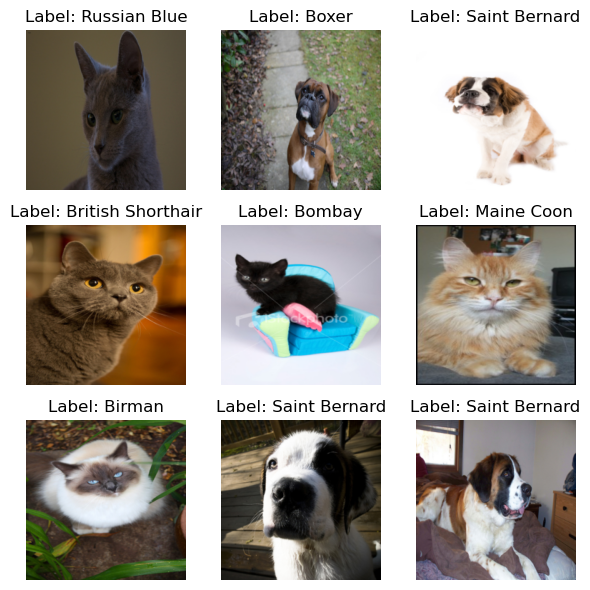

In [8]:
# 학습 데이터셋에서 9개의 이미지를 시각화합니다.
show_multiple_images(trainloader)

## 블록 구성하기

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [10]:
class BasicBlock(nn.Module):
    expansion = 1
    
    # 2 ~ 4번 스테이지의 첫 번째 블록의 1번 conv는 stride=2
    # conv 뒤에 bn이 있으면 관례적으로 bias는 없어도 된다고 함!
    
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride=stride, padding = 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride=1, padding = 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)  # 새로운 메모리를 만들지 않고 입력텐서를 직접 수정해서 결과를 덮어씀
        self.downsample = downsample
    
    def forward(self, x):
        identity = x if self.downsample is None else self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = out + identity
        out = self.relu(out)

        return out

In [11]:
class BottleNeck(nn.Module):
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x if self.downsample is None else self.downsample(x)
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out = out + identity
        out = self.relu(out)

        return out

In [12]:
class ResNet(nn.Module):
    
    def __init__(
        self,
        block_type=BasicBlock,
        num_block_list=[3, 4, 6, 3],
        channel_list=[64, 128, 256, 512],
        num_classes=37,
        in_channels=3
    ):

        super().__init__()
        assert len(num_block_list) == len(channel_list), "num_block_list와 channel_list 길이가 같아야 합니다."

        self.block_type = block_type
        
        # ---- Stem
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ---- Stages
        self.in_channels = 64
        self.layer1 = self._make_stage(num_block=num_block_list[0], out_channels=channel_list[0], stride=1)
        self.layer2 = self._make_stage(num_block=num_block_list[1], out_channels=channel_list[1], stride=2)
        self.layer3 = self._make_stage(num_block=num_block_list[2], out_channels=channel_list[2], stride=2)
        self.layer4 = self._make_stage(num_block=num_block_list[3], out_channels=channel_list[3], stride=2)

        # ---- Heads
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(channel_list[3] * self.block_type.expansion, num_classes)

    def _make_stage(self, num_block, out_channels, stride):
        layers = []

        expansion = self.block_type.expansion  # 블록 종류에 따라 채널 수가 블록 내에서 다를 수도 있기 때문
        
        downsample = None
        block_out_channels = out_channels * expansion
        if stride != 1 or self.in_channels != block_out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, block_out_channels, kernel_size = 1, stride=stride, bias=False),
                nn.BatchNorm2d(block_out_channels)
            )

        # 첫 Block
        layers.append(self.block_type(self.in_channels, out_channels, stride=stride, downsample=downsample))
        self.in_channels = block_out_channels
        
        # 나머지 Block
        for _ in range(1, num_block):
            layers.append(self.block_type(self.in_channels, out_channels, stride=1, downsample=None))

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)

        return out

In [13]:
def resnet34(num_classes=37, in_channels=3):
    return ResNet(
        block_type=BasicBlock,
        num_block_list=(3, 4, 6, 3),
        channel_list=(64, 128, 256, 512),
        num_classes=num_classes,
        in_channels=in_channels
    )


def resnet50(num_classes=37, in_channels=3):
    return ResNet(
        block_type=BottleNeck,
        num_block_list=(3, 4, 6, 3),
        channel_list=(64, 128, 256, 512),
        num_classes=num_classes,
        in_channels=in_channels
    )

In [14]:
summary(resnet34(num_classes=37), input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 37]                   --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

In [15]:
summary(resnet50(num_classes=37), input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 37]                   --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─BottleNeck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Sequential: 3-1              [1, 256, 56, 56]          16,896
│    │    └─Conv2d: 3-2                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-3             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-4                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-5                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-6             [1, 64, 56, 56]           12

## Plain-50, Plain-34 만들어보기

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [17]:
class PlainBasicBlock(nn.Module):
    expansion = 1
    
    # 2 ~ 4번 스테이지의 첫 번째 블록의 1번 conv는 stride=2
    # conv 뒤에 bn이 있으면 관례적으로 bias는 없어도 된다고 함!
    
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride=stride, padding = 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride=1, padding = 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)  # 새로운 메모리를 만들지 않고 입력텐서를 직접 수정해서 결과를 덮어씀
        # self.downsample = downsample
    
    def forward(self, x):
        # identity = x if self.downsample is None else self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        return out

In [18]:
class PlainBottleNeck(nn.Module):
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        # self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # identity = x if self.downsample is None else self.downsample(x)
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        # out = out + identity
        out = self.relu(out)

        return out

In [19]:
class Plain(nn.Module):
    
    def __init__(
        self,
        block_type=PlainBasicBlock,
        num_block_list=[3, 4, 6, 3],
        channel_list=[64, 128, 256, 512],
        num_classes=37,
        in_channels=3
    ):

        super().__init__()
        assert len(num_block_list) == len(channel_list), "num_block_list와 channel_list 길이가 같아야 합니다."

        self.block_type = block_type
        
        # ---- Stem
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ---- Stages
        self.in_channels = 64
        self.layer1 = self._make_stage(num_block=num_block_list[0], out_channels=channel_list[0], stride=1)
        self.layer2 = self._make_stage(num_block=num_block_list[1], out_channels=channel_list[1], stride=2)
        self.layer3 = self._make_stage(num_block=num_block_list[2], out_channels=channel_list[2], stride=2)
        self.layer4 = self._make_stage(num_block=num_block_list[3], out_channels=channel_list[3], stride=2)

        # ---- Heads
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(channel_list[3] * self.block_type.expansion, num_classes)

    def _make_stage(self, num_block, out_channels, stride):
        layers = []

        expansion = self.block_type.expansion  # 블록 종류에 따라 채널 수가 블록 내에서 다를 수도 있기 때문
        
        # downsample = None
        block_out_channels = out_channels * expansion
        # if stride != 1 or self.in_channels != block_out_channels:
        #     downsample = nn.Sequential(
        #         nn.Conv2d(self.in_channels, block_out_channels, kernel_size = 1, stride=stride, bias=False),
        #         nn.BatchNorm2d(block_out_channels)
        #     )

        # 첫 Block
        layers.append(self.block_type(self.in_channels, out_channels, stride=stride))
        self.in_channels = block_out_channels
        
        # 나머지 Block
        for _ in range(1, num_block):
            layers.append(self.block_type(self.in_channels, out_channels, stride=1))

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)

        return out

In [20]:
def plain34(num_classes=37, in_channels=3):
    return Plain(
        block_type=PlainBasicBlock,
        num_block_list=(3, 4, 6, 3),
        channel_list=(64, 128, 256, 512),
        num_classes=num_classes,
        in_channels=in_channels
    )


def plain50(num_classes=37, in_channels=3):
    return Plain(
        block_type=PlainBottleNeck,
        num_block_list=(3, 4, 6, 3),
        channel_list=(64, 128, 256, 512),
        num_classes=num_classes,
        in_channels=in_channels
    )

## 모델 학습시키기

### ResNet 모델

In [21]:
import time

In [22]:
BATCH_SIZE = 32
EPOCH = 25

In [23]:
# model 학습 및 검증 함수

def custom_model_train_validation(model):
    import time

    current_time = time.time()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    for param in model.parameters():
        param.requires_grad = True
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
    
    model_train_losses = []
    model_val_accuracy = []
    model_val_losses = []
    
    for epoch in range(EPOCH):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
    
        for i, (inputs, labels) in enumerate(trainloader, 0):
            inputs, labels = inputs.to(device), labels.to(device)
    
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
            if i % 100 == 99:
                print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / (i + 1):.3f}")
                
        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        model_train_losses.append(train_loss)
    
        print(f"Epoch {epoch + 1}: Train Accuracy: {train_acc:.2f}%")
    
        model.eval()
        correct = 0
        total = 0
        val_loss = 0.0
        
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)

                loss = criterion(outputs, labels)  # 검증 손실
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(testloader)
        val_acc = 100 * correct / total
        model_val_accuracy.append(val_acc)
        model_val_losses.append(val_loss)
    
        print(f"Epoch {epoch + 1}: Validation Accuracy: {val_acc:.2f}%, Validation Loss: {val_loss:.4f}")
    
    print("Finished Training")
    print(time.time() - current_time)

    return model_train_losses, model_val_accuracy, model_val_losses

In [24]:
# ResNet-34
resnet34_train_losses, resnet34_model_val_accuracy, resnet34_val_losses = custom_model_train_validation(resnet34(num_classes=37))

[1,   100] loss: 3.582
Epoch 1: Train Accuracy: 5.08%
Epoch 1: Validation Accuracy: 5.15%, Validation Loss: 3.8187
[2,   100] loss: 3.278
Epoch 2: Train Accuracy: 10.90%
Epoch 2: Validation Accuracy: 9.57%, Validation Loss: 3.9670
[3,   100] loss: 3.001
Epoch 3: Train Accuracy: 17.55%
Epoch 3: Validation Accuracy: 13.65%, Validation Loss: 3.1532
[4,   100] loss: 2.727
Epoch 4: Train Accuracy: 23.34%
Epoch 4: Validation Accuracy: 16.24%, Validation Loss: 3.0254
[5,   100] loss: 2.437
Epoch 5: Train Accuracy: 31.36%
Epoch 5: Validation Accuracy: 13.57%, Validation Loss: 3.5484
[6,   100] loss: 2.154
Epoch 6: Train Accuracy: 37.96%
Epoch 6: Validation Accuracy: 15.26%, Validation Loss: 3.6955
[7,   100] loss: 1.820
Epoch 7: Train Accuracy: 46.82%
Epoch 7: Validation Accuracy: 16.98%, Validation Loss: 3.2876
[8,   100] loss: 1.479
Epoch 8: Train Accuracy: 56.90%
Epoch 8: Validation Accuracy: 18.45%, Validation Loss: 3.4306
[9,   100] loss: 1.054
Epoch 9: Train Accuracy: 70.87%
Epoch 9: Val

In [25]:
# ResNet-50
resnet50_train_losses, resnet50_model_val_accuracy, resnet50_val_losses = custom_model_train_validation(resnet50(num_classes=37))

[1,   100] loss: 3.753
Epoch 1: Train Accuracy: 3.75%
Epoch 1: Validation Accuracy: 3.54%, Validation Loss: 4.3028
[2,   100] loss: 3.663
Epoch 2: Train Accuracy: 4.95%
Epoch 2: Validation Accuracy: 6.46%, Validation Loss: 3.6229
[3,   100] loss: 3.526
Epoch 3: Train Accuracy: 6.96%
Epoch 3: Validation Accuracy: 6.02%, Validation Loss: 3.6482
[4,   100] loss: 3.386
Epoch 4: Train Accuracy: 9.35%
Epoch 4: Validation Accuracy: 8.26%, Validation Loss: 3.6016
[5,   100] loss: 3.223
Epoch 5: Train Accuracy: 12.80%
Epoch 5: Validation Accuracy: 9.48%, Validation Loss: 3.4935
[6,   100] loss: 3.062
Epoch 6: Train Accuracy: 15.49%
Epoch 6: Validation Accuracy: 11.58%, Validation Loss: 3.3081
[7,   100] loss: 2.898
Epoch 7: Train Accuracy: 20.43%
Epoch 7: Validation Accuracy: 13.03%, Validation Loss: 3.2917
[8,   100] loss: 2.704
Epoch 8: Train Accuracy: 23.23%
Epoch 8: Validation Accuracy: 11.91%, Validation Loss: 3.4183
[9,   100] loss: 2.531
Epoch 9: Train Accuracy: 28.32%
Epoch 9: Validatio

In [26]:
# Plain-34
plain34_train_losses, plain34_model_val_accuracy, plain34_val_losses = custom_model_train_validation(plain34(num_classes=37))

[1,   100] loss: 3.629
Epoch 1: Train Accuracy: 3.18%
Epoch 1: Validation Accuracy: 3.98%, Validation Loss: 4.2016
[2,   100] loss: 3.562
Epoch 2: Train Accuracy: 4.89%
Epoch 2: Validation Accuracy: 4.88%, Validation Loss: 3.5566
[3,   100] loss: 3.495
Epoch 3: Train Accuracy: 6.17%
Epoch 3: Validation Accuracy: 6.70%, Validation Loss: 3.5739
[4,   100] loss: 3.399
Epoch 4: Train Accuracy: 8.32%
Epoch 4: Validation Accuracy: 6.84%, Validation Loss: 3.4334
[5,   100] loss: 3.322
Epoch 5: Train Accuracy: 10.43%
Epoch 5: Validation Accuracy: 7.52%, Validation Loss: 3.4417
[6,   100] loss: 3.249
Epoch 6: Train Accuracy: 11.58%
Epoch 6: Validation Accuracy: 10.47%, Validation Loss: 3.2973
[7,   100] loss: 3.169
Epoch 7: Train Accuracy: 12.93%
Epoch 7: Validation Accuracy: 10.98%, Validation Loss: 3.2818
[8,   100] loss: 3.060
Epoch 8: Train Accuracy: 15.19%
Epoch 8: Validation Accuracy: 11.50%, Validation Loss: 3.2990
[9,   100] loss: 2.989
Epoch 9: Train Accuracy: 17.09%
Epoch 9: Validatio

In [ ]:
# Plain-50
plain50_train_losses, plain50_model_val_accuracy, plain50_val_losses = custom_model_train_validation(plain50(num_classes=37))

[1,   100] loss: 3.635
Epoch 1: Train Accuracy: 3.48%


In [ ]:
import matplotlib.pyplot as plt

plt.plot(resnet_34_train_losses, 'r', label="ResNet-34 Training Loss")
plt.plot(resnet_50_train_losses, 'b', label="ResNet-50 Training Loss")

plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

### Training Loss 비교

In [ ]:
# Training Loss 비교

import matplotlib.pyplot as plt

plt.plot(resnet34_train_losses, 'r', label="ResNet-34 Training Loss")
plt.plot(resnet50_train_losses, 'b', label="ResNet-50 Training Loss")

plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

### 검증 정확도 비교

In [ ]:
# 검증 정확도 비교

plt.plot(resnet34_val_accuracy, 'r', label="ResNet-34 Validation Accuracy")
plt.plot(resnet50_val_accuracy, 'b', label="ResNet-50 Validation Accuracy")

plt.title('Model Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [ ]:
### ResNet-34 vs Plain-34 검증 정확도 비교
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1) ResNet-34 vs Plain-34
axes[0].plot(resnet34_val_accuracy, label="ResNet-34")
axes[0].plot(plain34_val_accuracy, label="Plain-34")
axes[0].set_title("ResNet-34 vs Plain-34")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Validation Accuracy")
axes[0].legend()
axes[0].grid(True)

# 2) ResNet-50 vs Plain-50
axes[1].plot(resnet50_val_accuracy, label="ResNet-50")
axes[1].plot(plain50_val_accuracy, label="Plain-50")
axes[1].set_title("ResNet-50 vs Plain-50")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Validation Accuracy")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
### ResNet-34 vs Plain-34 검증 손실 비교
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1) ResNet-34 vs Plain-34 (Validation Loss)
axes[0].plot(resnet34_val_losses, label="ResNet-34")
axes[0].plot(plain34_val_losses, label="Plain-34")
axes[0].set_title("ResNet-34 vs Plain-34 (Validation Loss)")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Validation Loss")
axes[0].legend()
axes[0].grid(True)

# 2) ResNet-50 vs Plain-50 (Validation Loss)
axes[1].plot(resnet50_val_losses, label="ResNet-50")
axes[1].plot(plain50_val_losses, label="Plain-50")
axes[1].set_title("ResNet-50 vs Plain-50 (Validation Loss)")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Validation Loss")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()
